## Hotel Reviews Classification

### Business Objective:-
Examine how travelers are communicating there experience in online platforms for staying in specific hotel. Major objective is what are the attributes that travelers are considering while selecting a hotel. With this manager can understand which elements of their hotel influence more in forming a positive review or improves hotel brand image.


In [1]:
# Importing required ibraries


import re
import string
import numpy as np
import pandas as pd
from tqdm.auto import tqdm

import nltk
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('omw-1.4')

from nltk.stem import WordNetLemmatizer
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk import word_tokenize

from sklearn.utils import shuffle
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


In [2]:
import pandas as pd
import spacy
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report
import warnings
warnings.filterwarnings("ignore")
# !pip install wordcloud
from wordcloud import WordCloud
!pip install afinn
from afinn import Afinn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 52 kB 1.1 MB/s 
  Created wheel for afinn: filename=afinn-0.1-py3-none-any.whl size=53448 sha256=4c233c89e3d6bb549a7b35286105fc6c5dbb770a59a70f01ffc953c9f7d2c562
  Stored in directory: /root/.cache/pip/wheels/9d/16/3a/9f0953027434eab5dadf3f33ab3298fa95afa8292fcf7aba75
Successfully built afinn


In [3]:
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
import numpy as np

# Models
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB, GaussianNB, CategoricalNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC

In [4]:
df = pd.read_excel("/content/sample_data/hotel_reviews.xlsx")

In [5]:
df

,Review,Rating
0,nice hotel expensive parking got good deal sta...,4.0
1,ok nothing special charge diamond member hilto...,2.0
2,nice rooms not 4* experience hotel monaco seat...,3.0
3,"unique, great stay, wonderful time hotel monac...",5.0
4,"great stay great stay, went seahawk game aweso...",5.0
...,...,...
20486,"best kept secret 3rd time staying charm, not 5...",5.0
20487,great location price view hotel great quick pl...,4.0
20488,"ok just looks nice modern outside, desk staff ...",2.0
20489,hotel theft ruined vacation hotel opened sept ...,1.0


In [6]:
df.isnull().sum()

Review    0
Rating    0
dtype: int64

In [7]:
df.Review[0]

'nice hotel expensive parking got good deal stay hotel anniversary, arrived late evening took advice previous reviews did valet parking, check quick easy, little disappointed non-existent view room room clean nice size, bed comfortable woke stiff neck high pillows, not soundproof like heard music room night morning loud bangs doors opening closing hear people talking hallway, maybe just noisy neighbors, aveda bath products nice, did not goldfish stay nice touch taken advantage staying longer, location great walking distance shopping, overall nice experience having pay 40 parking night,  '

In [8]:
df.Rating.value_counts()

5.0    9054
4.0    6039
3.0    2184
2.0    1793
1.0    1421
Name: Rating, dtype: int64

Text(0.5, 1.0, 'Distribution of Rating')

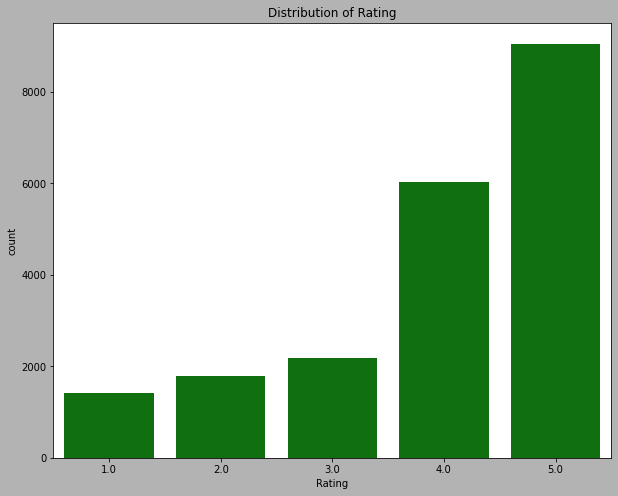

In [9]:
# Lets check the spread of ratings in our dataframe
plt.figure(figsize=(10, 8),facecolor='0.7')
sns.countplot(df.Rating, color="green")
plt.title("Distribution of Rating")

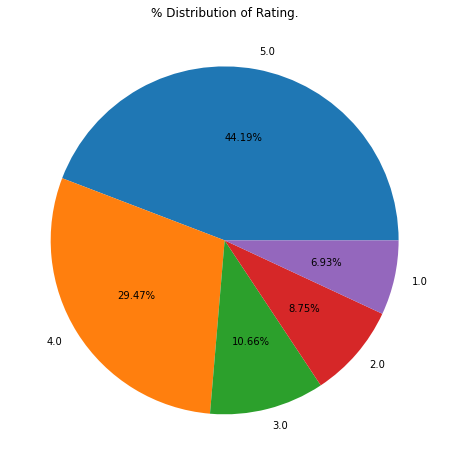

In [10]:
# % of distribution of ratings across the dataset
plt.figure(figsize=(10,8))
plt.pie(df['Rating'].value_counts(),labels=['5.0','4.0','3.0','2.0','1.0'], autopct='%1.2f%%')
plt.title("% Distribution of Rating.");

In [11]:
df.duplicated().sum()

0

#### Preprocessing

In [12]:
# Let's make a function to genrate WordCloud

def create_wordcloud(condition):
    """
    Takes the condition on the data which you want to generate a wordcloud and returns wordcloud image.
    Use plt.imshow() to view the generated wordcloud.
    """
    plt.figure(figsize=(20,20))
    wc = WordCloud(max_words=2000,
                   min_font_size=10,
                   height=800,
                   width=1600,
                   background_color="white").generate(" ".join(condition))
    return wc

In [13]:
# Some text cleaning functions

def convert_to_lower(text):
    return text.lower()

def remove_numbers(text):
    number_pattern = r'\d+'
    without_number = re.sub(pattern=number_pattern, repl=" ", string=text)
    return without_number

def lemmatizing(text):
    lemmatizer = WordNetLemmatizer()
    tokens = word_tokenize(text)
    for i in range(len(tokens)):
        lemma_word = lemmatizer.lemmatize(tokens[i])
        tokens[i] = lemma_word
    return " ".join(tokens)

def remove_punctuation(text):
    return text.translate(str.maketrans('', '', string.punctuation))

def remove_stopwords(text):
    removed = []
    stop_words = list(stopwords.words("english"))
    tokens = word_tokenize(text)
    for i in range(len(tokens)):
        if tokens[i] not in stop_words:
            removed.append(tokens[i])
    return " ".join(removed)

def remove_extra_white_spaces(text):
    single_char_pattern = r'\s+[a-zA-Z]\s+'
    without_sc = re.sub(pattern=single_char_pattern, repl=" ", string=text)
    return without_sc

In [14]:
# Applying data cleaning functions to `Reviews`

df["preprocessed_review"] = df['Review'].apply(lambda x: convert_to_lower(x))
df['preprocessed_review'] = df['preprocessed_review'].apply(lambda x: remove_numbers(x))
df['preprocessed_review'] = df['preprocessed_review'].apply(lambda x: remove_punctuation(x))
df['preprocessed_review'] = df['preprocessed_review'].apply(lambda x: remove_stopwords(x))
df['preprocessed_review'] = df['preprocessed_review'].apply(lambda x: remove_extra_white_spaces(x))
df['preprocessed_review'] = df['preprocessed_review'].apply(lambda x: lemmatizing(x))
df.head()

,Review,Rating,preprocessed_review
0,nice hotel expensive parking got good deal sta...,4.0,nice hotel expensive parking got good deal sta...
1,ok nothing special charge diamond member hilto...,2.0,ok nothing special charge diamond member hilto...
2,nice rooms not 4* experience hotel monaco seat...,3.0,nice room experience hotel monaco seattle good...
3,"unique, great stay, wonderful time hotel monac...",5.0,unique great stay wonderful time hotel monaco ...
4,"great stay great stay, went seahawk game aweso...",5.0,great stay great stay went seahawk game awesom...


In [15]:
df2 = df.copy()
df2.head()

,Review,Rating,preprocessed_review
0,nice hotel expensive parking got good deal sta...,4.0,nice hotel expensive parking got good deal sta...
1,ok nothing special charge diamond member hilto...,2.0,ok nothing special charge diamond member hilto...
2,nice rooms not 4* experience hotel monaco seat...,3.0,nice room experience hotel monaco seattle good...
3,"unique, great stay, wonderful time hotel monac...",5.0,unique great stay wonderful time hotel monaco ...
4,"great stay great stay, went seahawk game aweso...",5.0,great stay great stay went seahawk game awesom...


In [16]:
# Calculating length before and after preprocessing

df2["length_before_cleaning"] = df2["Review"].apply(lambda x: len(x))
df2["length_after_cleaning"] = df2["preprocessed_review"].apply(lambda x: len(x))
df2.head()

,Review,Rating,preprocessed_review,length_before_cleaning,length_after_cleaning
0,nice hotel expensive parking got good deal sta...,4.0,nice hotel expensive parking got good deal sta...,593,542
1,ok nothing special charge diamond member hilto...,2.0,ok nothing special charge diamond member hilto...,1689,1570
2,nice rooms not 4* experience hotel monaco seat...,3.0,nice room experience hotel monaco seattle good...,1427,1313
3,"unique, great stay, wonderful time hotel monac...",5.0,unique great stay wonderful time hotel monaco ...,600,562
4,"great stay great stay, went seahawk game aweso...",5.0,great stay great stay went seahawk game awesom...,1281,1171


In [17]:
# Dropping Rating column as we dont need it
df2.drop(["Rating"], axis=1, inplace=True)
df2.head()

,Review,preprocessed_review,length_before_cleaning,length_after_cleaning
0,nice hotel expensive parking got good deal sta...,nice hotel expensive parking got good deal sta...,593,542
1,ok nothing special charge diamond member hilto...,ok nothing special charge diamond member hilto...,1689,1570
2,nice rooms not 4* experience hotel monaco seat...,nice room experience hotel monaco seattle good...,1427,1313
3,"unique, great stay, wonderful time hotel monac...",unique great stay wonderful time hotel monaco ...,600,562
4,"great stay great stay, went seahawk game aweso...",great stay great stay went seahawk game awesom...,1281,1171


In [18]:
df3 = df2.drop(["Review"], axis=1)
df3.head()

,preprocessed_review,length_before_cleaning,length_after_cleaning
0,nice hotel expensive parking got good deal sta...,593,542
1,ok nothing special charge diamond member hilto...,1689,1570
2,nice room experience hotel monaco seattle good...,1427,1313
3,unique great stay wonderful time hotel monaco ...,600,562
4,great stay great stay went seahawk game awesom...,1281,1171


#### Sentiment Analysis 

In [19]:
#we use affin lexicon for SA

# Sentiment analysis functions.

afinn = Afinn()

def afn_score(text):
    """Gives Afinn score provided to the text.
    """
    score = afinn.score(text)
    return score

In [20]:
df3["afinn_score"] = df3["preprocessed_review"].apply(afn_score)
df3.head()

,preprocessed_review,length_before_cleaning,length_after_cleaning,afinn_score
0,nice hotel expensive parking got good deal sta...,593,542,26.0
1,ok nothing special charge diamond member hilto...,1689,1570,40.0
2,nice room experience hotel monaco seattle good...,1427,1313,20.0
3,unique great stay wonderful time hotel monaco ...,600,562,39.0
4,great stay great stay went seahawk game awesom...,1281,1171,40.0


In [21]:
# Label encoding `afinn_score`

def sentiment_analysis(score):
    """Checks the score. If the score < 0 then `1` and if the score > 0 then `-1` otherwise `0`.
    """
    if score > 0:
        return 1
    elif score < 0:
        return -1
    else:
        return 0


df3["sentiment"] = df3["afinn_score"].apply(sentiment_analysis) 
df3.head()

,preprocessed_review,length_before_cleaning,length_after_cleaning,afinn_score,sentiment
0,nice hotel expensive parking got good deal sta...,593,542,26.0,1
1,ok nothing special charge diamond member hilto...,1689,1570,40.0,1
2,nice room experience hotel monaco seattle good...,1427,1313,20.0,1
3,unique great stay wonderful time hotel monaco ...,600,562,39.0,1
4,great stay great stay went seahawk game awesom...,1281,1171,40.0,1


In [22]:
df3.sentiment.value_counts()

 1    18992
-1     1294
 0      205
Name: sentiment, dtype: int64

In [23]:
# Saving the `preprocessed_dataframe`

df3.to_csv("Preprocessed-dataframe.csv", index=None)

In [25]:
df3 = pd.read_csv("/content/Preprocessed-dataframe.csv")

#### Model Building
##### First we will try model building without balancing dataframe. 

In [26]:
df3.head()

,preprocessed_review,length_before_cleaning,length_after_cleaning,afinn_score,sentiment
0,nice hotel expensive parking got good deal sta...,593,542,26.0,1
1,ok nothing special charge diamond member hilto...,1689,1570,40.0,1
2,nice room experience hotel monaco seattle good...,1427,1313,20.0,1
3,unique great stay wonderful time hotel monaco ...,600,562,39.0,1
4,great stay great stay went seahawk game awesom...,1281,1171,40.0,1


In [27]:
df4 = df3.drop(["length_before_cleaning", "length_after_cleaning", "afinn_score"], axis=1)
df4.head()

,preprocessed_review,sentiment
0,nice hotel expensive parking got good deal sta...,1
1,ok nothing special charge diamond member hilto...,1
2,nice room experience hotel monaco seattle good...,1
3,unique great stay wonderful time hotel monaco ...,1
4,great stay great stay went seahawk game awesom...,1


In [28]:
# Vectorizing the `preprocessed_review`

tfidf_wo_balanc = TfidfVectorizer(max_features=5000)
X_tf_wob = tfidf_wo_balanc.fit_transform(df3["preprocessed_review"]).toarray()
X_tf_wob

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [29]:
print(X_tf_wob.shape)

(20491, 5000)


In [30]:
#Train test split

X_train_tf_wob, X_test_tf_wob, y_train_tf_wob, y_test_tf_wob = train_test_split(X_tf_wob, df3["sentiment"].values, test_size=0.2)

#### Naive Bayes

In [31]:
# Instantiating model building
naiveBayes_wob = GaussianNB()

# FItting the train data
naiveBayes_wob.fit(X_train_tf_wob, y_train_tf_wob)

# Making predictions
y_pred_tf_wob = naiveBayes_wob.predict(X_test_tf_wob)

In [32]:
# Checking accuracy
print(accuracy_score(y_test_tf_wob, y_pred_tf_wob))

0.6955354964625519


In [33]:
# Classification report
print(classification_report(y_test_tf_wob, y_pred_tf_wob))

              precision    recall  f1-score   support

          -1       0.11      0.51      0.19       257
           0       0.02      0.04      0.03        53
           1       0.95      0.72      0.82      3789

    accuracy                           0.70      4099
   macro avg       0.36      0.42      0.34      4099
weighted avg       0.89      0.70      0.77      4099



#### KNN

In [36]:
knn_wob = KNeighborsClassifier()

# FItting the train data
knn_wob.fit(X_train_tf_wob, y_train_tf_wob)

# Making predictions
y_pred_tf_wob = knn_wob.predict(X_test_tf_wob)

In [37]:
# Checking accuracy
print(accuracy_score(y_test_tf_wob, y_pred_tf_wob))

0.9314466943156867


In [38]:
# Classification report
print(classification_report(y_test_tf_wob, y_pred_tf_wob))

              precision    recall  f1-score   support

          -1       0.64      0.21      0.32       257
           0       0.00      0.00      0.00        53
           1       0.94      0.99      0.97      3789

    accuracy                           0.93      4099
   macro avg       0.53      0.40      0.43      4099
weighted avg       0.91      0.93      0.91      4099



#### Decision Tree

In [39]:

tree_wob = DecisionTreeClassifier()

# FItting the train data
tree_wob.fit(X_train_tf_wob, y_train_tf_wob)

# Making predictions
y_pred_tf_wob = tree_wob.predict(X_test_tf_wob)

In [40]:
# Checking accuracy
print(accuracy_score(y_test_tf_wob, y_pred_tf_wob))

0.9080263478897292


In [41]:
# Classification report
print(classification_report(y_test_tf_wob, y_pred_tf_wob))

              precision    recall  f1-score   support

          -1       0.40      0.47      0.43       257
           0       0.10      0.06      0.07        53
           1       0.96      0.95      0.95      3789

    accuracy                           0.91      4099
   macro avg       0.48      0.49      0.49      4099
weighted avg       0.91      0.91      0.91      4099



In [42]:
#All the above models are very similar in accuracy. 
#But Decision tree classifier is doing well with classification. We will move forward with it

In [43]:
# Let's try buiding a model with balanced dataframe

df3.head()

,preprocessed_review,length_before_cleaning,length_after_cleaning,afinn_score,sentiment
0,nice hotel expensive parking got good deal sta...,593,542,26.0,1
1,ok nothing special charge diamond member hilto...,1689,1570,40.0,1
2,nice room experience hotel monaco seattle good...,1427,1313,20.0,1
3,unique great stay wonderful time hotel monaco ...,600,562,39.0,1
4,great stay great stay went seahawk game awesom...,1281,1171,40.0,1


In [44]:
df4 = df3.drop(["length_before_cleaning", "length_after_cleaning", "afinn_score"], axis=1)
df4.head()

,preprocessed_review,sentiment
0,nice hotel expensive parking got good deal sta...,1
1,ok nothing special charge diamond member hilto...,1
2,nice room experience hotel monaco seattle good...,1
3,unique great stay wonderful time hotel monaco ...,1
4,great stay great stay went seahawk game awesom...,1


In [45]:
df4_pos = df4[df4["sentiment"] ==1]
df4_pos.head()
len(df4_pos)

18992

In [46]:
# Down sampling positive reviews

df4_pos_sampled = df4_pos.sample(5000, replace=True)
df4_pos_sampled.head()

,preprocessed_review,sentiment
9311,fantastic location hotel sandwiched main la ra...,1
16987,nice hotel western hotel accommodation really ...,1
396,wonderful week say good thing hotel service co...,1
20433,great hotel write review hotel ca nt say good ...,1
12663,good stay ruined noise hotel nice clean room c...,1


In [47]:
# Making negative and neutral review dataframes

df4_neg = df4[df4["sentiment"] == -1]
df4_neut = df4[df4["sentiment"] == 0]

In [48]:
df4_neg.shape, df4_neut.shape

((1294, 2), (205, 2))

In [49]:
df5 = pd.concat([df4_pos_sampled, df4_neg, df4_neut], axis=0)
df5.shape

(6499, 2)

In [50]:
df5.head()

,preprocessed_review,sentiment
9311,fantastic location hotel sandwiched main la ra...,1
16987,nice hotel western hotel accommodation really ...,1
396,wonderful week say good thing hotel service co...,1
20433,great hotel write review hotel ca nt say good ...,1
12663,good stay ruined noise hotel nice clean room c...,1


In [51]:
df5.sentiment.value_counts()

 1    5000
-1    1294
 0     205
Name: sentiment, dtype: int64

#### Augmentation

In [52]:
# Let's do augmentation to balance the minority class
!pip install transformers
!pip install nlpaug

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.5 MB 14.2 MB/s 
     |████████████████████████████████| 7.6 MB 3.9 MB/s 
     |████████████████████████████████| 163 kB 67.6 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 410 kB 10.0 MB/s 


In [53]:

import nlpaug.augmenter.word.context_word_embs as aug

In [54]:
# Let's see the working example

sample_text = df["preprocessed_review"].iloc[100]
sample_text

'great location staff location price make older hotel good choice staff friendly looking modern place old studio apartment building run hotel great neighborhood close great local resturants hotel sterile tourist feeling newer mid range hotel feel like small european hotel yes room use little moderizing compermise reservation stay'

In [55]:
# Initiate the augmentor

augmenter = aug.ContextualWordEmbsAug(model_path='bert-base-uncased', action="insert")

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/440M [00:00<?, ?B/s]

In [56]:
augmented_sample_text = augmenter.augment(sample_text)
augmented_sample_text

['hotels great location staff location different price to make older hotel good building choice staff friendly looking building modern financial place old studio apartment building run hotel great neighborhood historic close great local resturants hotel sterile tourist parking feeling of newer mid middle range hotel feel like small european hotel yes room use little moderizing compermise reservation stay']

In [57]:
df5["sentiment"].value_counts()

 1    5000
-1    1294
 0     205
Name: sentiment, dtype: int64

In [58]:
df6 = pd.concat([df4_pos_sampled, df4_neg], axis=0)
df6["sentiment"].value_counts()

 1    5000
-1    1294
Name: sentiment, dtype: int64

In [59]:
df4_neut["sentiment"].value_counts()

0    205
Name: sentiment, dtype: int64

In [60]:
 def augmentMyData(df, augmenter, repetitions=1, samples=200):
     augmented_texts = []
     # select only the minority class samples
     spam_df = df[df["sentiment"] == -1].reset_index(drop=True) # removes unecessary index column
     for i in tqdm(np.random.randint(0, len(spam_df), samples)):
         # generating 'n_samples' augmented texts
         for _ in range(repetitions):
             augmented_text = augmenter.augment(spam_df["preprocessed_review"].iloc[i])
             augmented_texts.append(augmented_text)
    
     data = {
         "sentiment": -1,
         "preprocessed_review": augmented_texts
     }
     aug_df = pd.DataFrame(data)
     df = shuffle(df.append(aug_df).reset_index(drop=True))
     return df


 aug_df = augmentMyData(df6, augmenter, samples=1000)
 aug_df["sentiment"].value_counts()

  0%|          | 0/1000 [00:00<?, ?it/s]

 1    5000
-1    2294
Name: sentiment, dtype: int64

In [61]:
aug_df.to_csv("aug_data.csv", index=None)

In [64]:
aug_df = pd.read_csv("/content/aug_data.csv")

In [65]:
aug_df.sentiment.value_counts()

 1    5000
-1    2294
Name: sentiment, dtype: int64

In [66]:
df_neg = aug_df[aug_df["sentiment"] == -1]
df_neg.shape

(2294, 2)

In [67]:
df4_neut.shape

(205, 2)

In [68]:
neg_neut_df = pd.concat([df_neg, df4_neut], axis=0)
neg_neut_df.shape

(2499, 2)

In [69]:

neg_neut_df.sentiment.value_counts()

-1    2294
 0     205
Name: sentiment, dtype: int64

In [70]:

def augmentMyData(df, augmenter, repetitions=1, samples=200):
    augmented_texts = []
    # select only the minority class samples
    spam_df = df[df["sentiment"] == 0].reset_index(drop=True) # removes unecessary index column
    for i in tqdm(np.random.randint(0, len(spam_df), samples)):
        # generating 'n_samples' augmented texts
        for _ in range(repetitions):
            augmented_text = augmenter.augment(spam_df["preprocessed_review"].iloc[i])
            augmented_texts.append(augmented_text)
    
    data = {
        "sentiment": 0,
        "preprocessed_review": augmented_texts
    }
    aug_df = pd.DataFrame(data)
    df = shuffle(df.append(aug_df).reset_index(drop=True))
    return df


aug_neg_neut_df = augmentMyData(neg_neut_df, augmenter)
aug_neg_neut_df.sentiment.value_counts()


  0%|          | 0/200 [00:00<?, ?it/s]

-1    2294
 0     405
Name: sentiment, dtype: int64

In [71]:

aug_neg_neut_df.to_csv("aug_neg_neut_df.csv", index=False)

In [72]:
aug_neg_neut_df.sentiment.value_counts()

-1    2294
 0     405
Name: sentiment, dtype: int64

In [73]:
aug_neut_sent_df = aug_neg_neut_df[aug_neg_neut_df["sentiment"] == 0]
aug_neut_sent_df.sentiment.value_counts()

0    405
Name: sentiment, dtype: int64

In [74]:
final_df = pd.concat([aug_neut_sent_df, aug_df], axis=0)
final_df.sentiment.value_counts()

 1    5000
-1    2294
 0     405
Name: sentiment, dtype: int64

In [75]:
df10 = pd.DataFrame(final_df)
df10.head()

,preprocessed_review,sentiment
2491,pas ach leidse square pas hotel room small din...,0
2552,[big disappointment wife booked square foot lu...,0
2478,disapponted booked hotel night celebrate honey...,0
2516,[good value hotel quiet room visit new orleans...,0
2559,[noisy uncomfortable horrible service staff ga...,0


In [76]:
# As some reviews changed to list we need to convert them into strings

df10 = df10.astype({"preprocessed_review": str})
df10.head()

,preprocessed_review,sentiment
2491,pas ach leidse square pas hotel room small din...,0
2552,['big disappointment wife booked square foot l...,0
2478,disapponted booked hotel night celebrate honey...,0
2516,['good value hotel quiet room visit new orlean...,0
2559,['noisy uncomfortable horrible service staff g...,0


In [77]:
df4.head()

,preprocessed_review,sentiment
0,nice hotel expensive parking got good deal sta...,1
1,ok nothing special charge diamond member hilto...,1
2,nice room experience hotel monaco seattle good...,1
3,unique great stay wonderful time hotel monaco ...,1
4,great stay great stay went seahawk game awesom...,1


In [78]:
# split the dataset before augmenting to avoid augmented data in valid set
X_train, _, y_train, _ = train_test_split(df10["preprocessed_review"], df10["sentiment"].values, test_size=0.1)
_, X_test, _, y_test = train_test_split(df4["preprocessed_review"], df4["sentiment"].values, test_size=0.5)

In [79]:
tf_with_aug = TfidfVectorizer(max_features=5000)
X_train_tf = tf_with_aug.fit_transform(X_train)
X_train_tf = X_train_tf.toarray()

In [80]:
tree_bal = DecisionTreeClassifier()

# FItting the train data
tree_bal.fit(X_train_tf, y_train)

# Transforming the test data
X_test_tf = tf_with_aug.transform(X_test).toarray()

# Making predictions
y_pred_tf = tree_bal.predict(X_test_tf)

In [81]:
# Checking accuracy
print(accuracy_score(y_test, y_pred_tf))

0.9143080226429826


In [82]:
# Classification report
print(classification_report(y_test, y_pred_tf))

              precision    recall  f1-score   support

          -1       0.48      0.98      0.65       654
           0       0.38      0.95      0.54       113
           1       1.00      0.91      0.95      9479

    accuracy                           0.91     10246
   macro avg       0.62      0.94      0.71     10246
weighted avg       0.96      0.91      0.93     10246



In [83]:
# We can see we have a great improvement with f1-scores in above trained model. Let's save the model and vectorizer.

import pickle

# Saving the vectorizer
pickle.dump(tf_with_aug, open("vectorizer_aug_tf.pickle", "wb"))

# Saving the model
pickle.dump(tree_bal, open("decsn_tree_trained_aug.pickle", "wb"))